### 4_Modeling / modeling_v1.ipynb

##### 📌 1. 데이터 로드 & 전처리 결과 확인

In [75]:
# 1. 공통 설정 & 경로 세팅

# =====================
# 1. 표준 라이브러리
# =====================
from pathlib import Path

# =====================
# 2. 서드파티 라이브러리
# =====================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False

# 프로젝트 루트 추정 (현재: dacon/notebooks/4_Modeling 기준)
# 필요 시 한 번 print 찍어보고 수정!
CURRENT_DIR = Path.cwd().resolve()
PROJECT_DIR = CURRENT_DIR.parents[1]   # .. /notebooks -> .. (프로젝트 루트)
DATA_DIR = PROJECT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"

print("📁 CURRENT_DIR :", CURRENT_DIR)
print("📁 PROJECT_DIR :", PROJECT_DIR)
print("📁 PROCESSED_DIR :", PROCESSED_DIR)

📁 CURRENT_DIR : /root/dacon/notebooks/4_Modeling
📁 PROJECT_DIR : /root/dacon
📁 PROCESSED_DIR : /root/dacon/data/processed


In [76]:
# 1-1. preprocessing_v2 결과 로드

feat_path = PROCESSED_DIR / "train_monthly_with_features_v1.parquet"
pairs_v1_path = PROCESSED_DIR / "candidate_pairs_v1.csv"  # 이름 다를 경우 수정 필요

df_feat = pd.read_parquet(feat_path)
candidate_pairs_v1 = pd.read_csv(pairs_v1_path)

print("📦 df_feat shape:", df_feat.shape)
print("🧩 candidate_pairs_v1 shape:", candidate_pairs_v1.shape)
display(df_feat.head())

📦 df_feat shape: (3776, 18)
🧩 candidate_pairs_v1 shape: (64, 3)


,item_id,year,month,value,weight,quantity,date,ym,hs4,type,value_log,weight_log,value_per_kg,value_lag_1,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3
0,AANGBULD,2022,1,14276.0,17625.0,0.0,2022-01-01,2022-01,4810,1,9.566405,9.777130,0.809986,NaN,NaN,NaN,NaN,NaN
1,AANGBULD,2022,2,52347.0,67983.0,0.0,2022-02-01,2022-02,4810,1,10.865669,11.127028,0.770001,14276.0,NaN,38071.0,2.666783,NaN
2,AANGBULD,2022,3,53549.0,69544.0,0.0,2022-03-01,2022-03,4810,1,10.888371,11.149729,0.770002,52347.0,14276.0,1202.0,0.022962,40057.333333
3,AANGBULD,2022,5,26997.0,34173.0,0.0,2022-05-01,2022-05,4810,1,10.203518,10.439220,0.790010,53549.0,52347.0,-26552.0,-0.495845,44297.666667
4,AANGBULD,2022,6,84489.0,103666.0,0.0,2022-06-01,2022-06,4810,1,11.344388,11.548939,0.815012,26997.0,53549.0,57492.0,2.129570,55011.666667


📆 ym 기간: 2022-01 → 2025-07
📦 item 개수: 100
📊 컬럼 목록:
 ['item_id', 'year', 'month', 'value', 'weight', 'quantity', 'date', 'ym', 'hs4', 'type', 'value_log', 'weight_log', 'value_per_kg', 'value_lag_1', 'value_lag_2', 'value_diff_1', 'value_pct_change_1', 'value_roll_mean_3']
📊 월별 value 합계 상위 5개:


,ym,value
0,2022-01,696534744.0
1,2022-02,538911879.0
2,2022-03,607177801.0
3,2022-04,591170783.0
4,2022-05,626300913.0


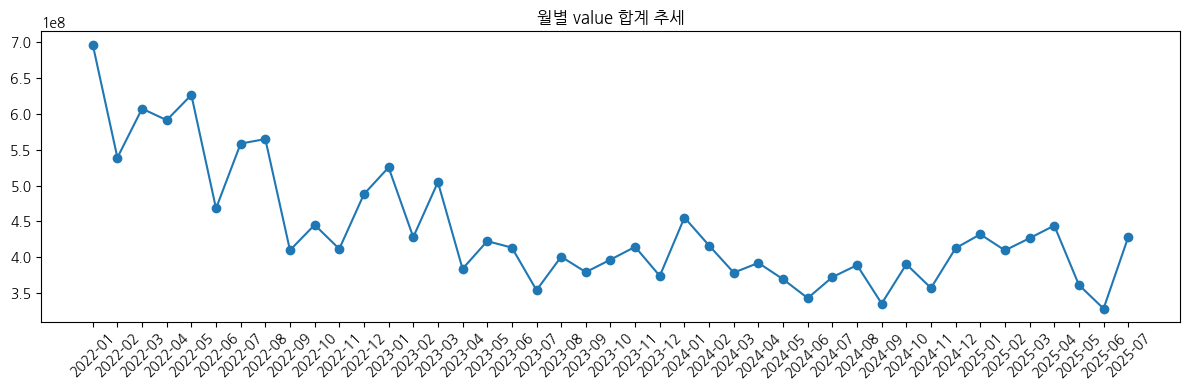

In [77]:
# 1-2. df_feat EDA: 기간, item 수, 주요 컬럼 확인

print("📆 ym 기간:", df_feat["ym"].min(), "→", df_feat["ym"].max())
print("📦 item 개수:", df_feat["item_id"].nunique())
print("📊 컬럼 목록:\n", df_feat.columns.tolist())

# 월별 value 합계 변화 추세 간단 확인
monthly_sum = (
    df_feat.groupby("ym")["value"]
    .sum()
    .reset_index()
    .sort_values("ym")
)

print("📊 월별 value 합계 상위 5개:")
display(monthly_sum.head())

plt.figure(figsize=(12, 4))
plt.plot(monthly_sum["ym"], monthly_sum["value"], marker="o")
plt.xticks(rotation=45)
plt.title("월별 value 합계 추세")
plt.tight_layout()
plt.show()

🔗 candidate_pairs_v1 컬럼: ['item_a', 'item_b', 'corr']
🧮 상관계수 통계:


count    64.000000
mean      0.578257
std       0.061399
min       0.500840
25%       0.523462
50%       0.570941
75%       0.603449
max       0.740727
Name: corr, dtype: float64

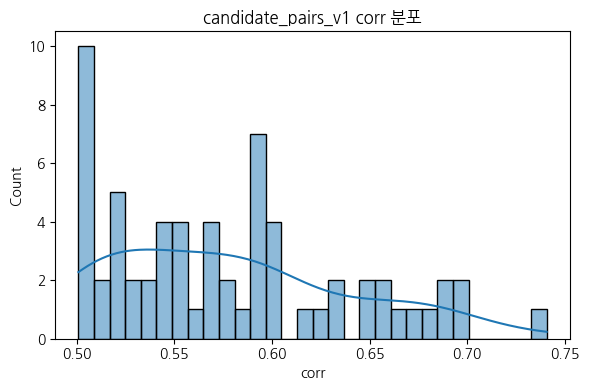

🔍 corr 상위 5개:


,item_a,item_b,corr
0,QRKRBYJL,SDWAYPIK,0.740727
1,DNMPSKTB,XUOIQPFL,0.699396
2,QVLMOEYE,SDWAYPIK,0.695905
3,GYHKIVQT,QVLMOEYE,0.687429
4,ATLDMDBO,QVLMOEYE,0.685555


In [78]:
# 1-3. candidate_pairs_v1 EDA

print("🔗 candidate_pairs_v1 컬럼:", candidate_pairs_v1.columns.tolist())
print("🧮 상관계수 통계:")
display(candidate_pairs_v1["corr"].describe())

plt.figure(figsize=(6, 4))
sns.histplot(candidate_pairs_v1["corr"], bins=30, kde=True)
plt.title("candidate_pairs_v1 corr 분포")
plt.tight_layout()
plt.show()

print("🔍 corr 상위 5개:")
display(candidate_pairs_v1.sort_values("corr", ascending=False).head())

##### 📌 2. 공행성(comovement) 쌍 선정 (lag + 방향성)

In [79]:
# 2-1. 월별 value pivot 생성 (item_id × ym)

# ym 정렬을 위해 일단 카테고리/정렬 처리
df_feat_sorted = df_feat.sort_values(["ym", "item_id"])

pivot_value = df_feat_sorted.pivot(
    index="item_id",
    columns="ym",
    values="value"
)

print("📦 pivot_value shape:", pivot_value.shape)
display(pivot_value.iloc[:5, :5])

📦 pivot_value shape: (100, 43)


ym,2022-01,2022-02,2022-03,2022-04,2022-05
item_id,,,,,
AANGBULD,14276.0,52347.0,53549.0,NaN,26997.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0
ANWUJOKX,NaN,NaN,NaN,63580.0,81670.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0


🧮 item별 non-zero 개수 통계:


count    100.0
mean      43.0
std        0.0
min       43.0
25%       43.0
50%       43.0
75%       43.0
max       43.0
dtype: float64

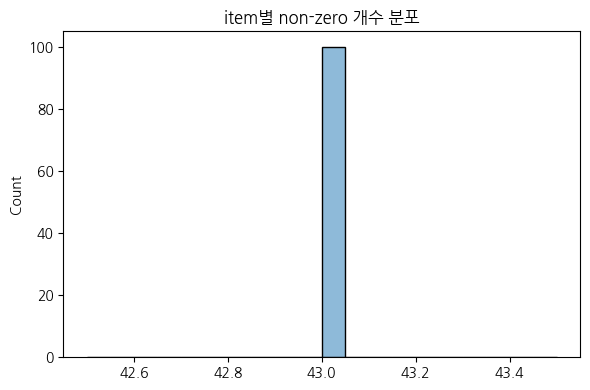

In [80]:
# 2-1-추가. item별 비-0 value 개수 분포

nonzero_counts = (pivot_value != 0).sum(axis=1)

print("🧮 item별 non-zero 개수 통계:")
display(nonzero_counts.describe())

plt.figure(figsize=(6, 4))
sns.histplot(nonzero_counts, bins=20, kde=True)
plt.title("item별 non-zero 개수 분포")
plt.tight_layout()
plt.show()

In [81]:
# 2-2. lag 기반 상관계수 계산 함수 정의

def safe_corr(x: np.ndarray, y: np.ndarray) -> float:
    """분산 0 방지용 상관계수 계산 함수."""
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])


def find_best_lag_for_pair(
    a_series: np.ndarray,
    b_series: np.ndarray,
    max_lag: int = 6,
    min_overlap: int = 12
):
    """
    하나의 (leader, follower) 시계열에 대해
    0 ~ max_lag 까지 lag 를 탐색하며 |corr|가 가장 큰 lag와 corr 반환.
    """
    best_corr = 0.0
    best_lag = 0
    n = len(a_series)

    for lag in range(0, max_lag + 1):
        if lag == 0:
            x = a_series
            y = b_series
        else:
            x = a_series[:-lag]
            y = b_series[lag:]

        # 둘 다 0이 아닌 구간만 사용 (실질적인 공행성 구간)
        mask = (x != 0) & (y != 0)
        if mask.sum() < min_overlap:
            continue

        corr = safe_corr(x[mask], y[mask])

        if abs(corr) > abs(best_corr):
            best_corr = corr
            best_lag = lag

    return best_lag, best_corr

In [82]:
# 2-3. candidate_pairs_v1 을 대상으로 lag + 방향성 계산

def find_comovement_pairs_v2(
    pivot: pd.DataFrame,
    candidates: pd.DataFrame,
    max_lag: int = 6,
    min_overlap: int = 12,
    corr_threshold: float = 0.4
) -> pd.DataFrame:
    """
    candidate_pairs_v1 (item_a, item_b, corr)를 입력으로 받아
    leader/follower와 best_lag, max_corr를 계산하는 v2 함수.
    - pivot: index=item_id, columns=ym, values=value
    """
    results = []

    # 컬럼 이름 가정: item_a, item_b, corr
    for _, row in tqdm(candidates.iterrows(), total=len(candidates)):
        item_a = row["item_a"]
        item_b = row["item_b"]

        if item_a not in pivot.index or item_b not in pivot.index:
            continue

        a_series = pivot.loc[item_a].values.astype(float)
        b_series = pivot.loc[item_b].values.astype(float)

        # A를 leader, B를 follower로 가정한 경우
        lag_ab, corr_ab = find_best_lag_for_pair(
            a_series, b_series,
            max_lag=max_lag,
            min_overlap=min_overlap
        )

        # B를 leader, A를 follower로 가정한 경우
        lag_ba, corr_ba = find_best_lag_for_pair(
            b_series, a_series,
            max_lag=max_lag,
            min_overlap=min_overlap
        )

        # 두 방향 중 |corr|가 큰 쪽을 최종 선택
        if abs(corr_ab) >= abs(corr_ba):
            leader = item_a
            follower = item_b
            best_lag = lag_ab
            max_corr = corr_ab
        else:
            leader = item_b
            follower = item_a
            best_lag = lag_ba
            max_corr = corr_ba

        if abs(max_corr) < corr_threshold:
            continue

        results.append(
            {
                "leading_item_id": leader,
                "following_item_id": follower,
                "best_lag": best_lag,
                "max_corr": max_corr,
            }
        )

    return pd.DataFrame(results)

In [83]:
# 2-4. comovement_pairs_v2 계산 실행

comovement_pairs_v2 = find_comovement_pairs_v2(
    pivot=pivot_value,
    candidates=candidate_pairs_v1,
    max_lag=6,
    min_overlap=12,
    corr_threshold=0.4  # 필요 시 튜닝
)

print("✅ comovement_pairs_v2 생성 완료!")
print("📦 comovement_pairs_v2 shape:", comovement_pairs_v2.shape)
display(comovement_pairs_v2.head())

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:00<00:00, 672.06it/s]

✅ comovement_pairs_v2 생성 완료!
📦 comovement_pairs_v2 shape: (53, 4)


,leading_item_id,following_item_id,best_lag,max_corr
0,QRKRBYJL,SDWAYPIK,0,0.794249
1,DNMPSKTB,XUOIQPFL,0,0.754678
2,SDWAYPIK,QVLMOEYE,2,0.730036
3,GYHKIVQT,QVLMOEYE,0,0.665974
4,ATLDMDBO,QVLMOEYE,3,0.703682


🧮 best_lag 통계:


count    53.000000
mean      1.622642
std       1.992548
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: best_lag, dtype: float64

🧮 max_corr 통계:


count    53.000000
mean      0.641986
std       0.094626
min       0.423034
25%       0.557845
50%       0.647536
75%       0.713218
max       0.844230
Name: max_corr, dtype: float64

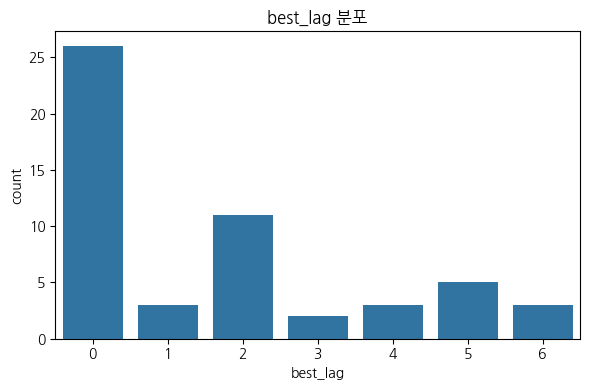

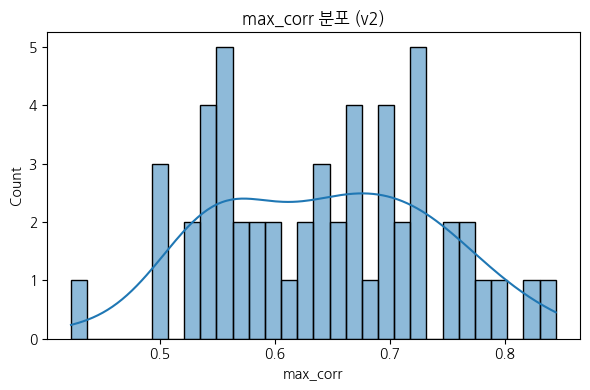

In [84]:
# 2-5. comovement_pairs_v2 EDA

print("🧮 best_lag 통계:")
display(comovement_pairs_v2["best_lag"].describe())

print("🧮 max_corr 통계:")
display(comovement_pairs_v2["max_corr"].describe())

plt.figure(figsize=(6, 4))
sns.countplot(x="best_lag", data=comovement_pairs_v2)
plt.title("best_lag 분포")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(comovement_pairs_v2["max_corr"], bins=30, kde=True)
plt.title("max_corr 분포 (v2)")
plt.tight_layout()
plt.show()

In [85]:
# 2-6. comovement_pairs_v2 저장

pairs_v2_path = PROCESSED_DIR / "comovement_pairs_v2.csv"
comovement_pairs_v2.to_csv(pairs_v2_path, index=False)

print("💾 comovement_pairs_v2 저장 완료:", pairs_v2_path)

💾 comovement_pairs_v2 저장 완료: /root/dacon/data/processed/comovement_pairs_v2.csv


##### 📌 3. 학습용 피처 데이터셋 구축 (X, y)

In [86]:
# 3-1. ym을 정렬 가능한 시간 인덱스(t_idx)로 변환 + target 생성

# ym 고유값 정렬 후 t_idx 부여
ym_order = (
    df_feat[["ym"]]
    .drop_duplicates()
    .sort_values("ym")
    .reset_index(drop=True)
)
ym_order["t_idx"] = np.arange(len(ym_order))

df_feat = df_feat.merge(ym_order, on="ym", how="left")

# item_id별로 t_idx 기준 정렬
df_feat = df_feat.sort_values(["item_id", "t_idx"])

# 다음 달 value를 target으로 사용
df_feat["target_value_next"] = (
    df_feat.groupby("item_id")["value"]
    .shift(-1)
)

print("🕒 ym → t_idx 매핑 예시")
display(ym_order.head())

print("🎯 target_value_next 생성 완료!")
display(df_feat[["item_id", "ym", "t_idx", "value", "target_value_next"]].head(10))

🕒 ym → t_idx 매핑 예시


,ym,t_idx
0,2022-01,0
1,2022-02,1
2,2022-03,2
3,2022-04,3
4,2022-05,4


🎯 target_value_next 생성 완료!


,item_id,ym,t_idx,value,target_value_next
0,AANGBULD,2022-01,0,14276.0,52347.0
1,AANGBULD,2022-02,1,52347.0,53549.0
2,AANGBULD,2022-03,2,53549.0,26997.0
3,AANGBULD,2022-05,4,26997.0,84489.0
4,AANGBULD,2022-06,5,84489.0,299.0
5,AANGBULD,2022-11,10,299.0,574.0
6,AANGBULD,2022-12,11,574.0,41353.0
7,AANGBULD,2023-02,13,41353.0,26524.0
8,AANGBULD,2023-05,16,26524.0,340.0
9,AANGBULD,2023-06,17,340.0,41142.0


In [87]:
# 3-1-추가. t_idx 범위 및 target 존재 비율 확인

print("🕒 t_idx 범위:", int(df_feat["t_idx"].min()), "→", int(df_feat["t_idx"].max()))

total_rows = len(df_feat)
target_non_null = df_feat["target_value_next"].notnull().sum()
print(f"📊 target_value_next 존재 비율: {target_non_null} / {total_rows} = {target_non_null/total_rows:.3f}")

# item_id 별로 target이 존재하는 시점 개수 분포
target_counts = (
    df_feat.groupby("item_id")["target_value_next"]
    .apply(lambda s: s.notnull().sum())
)

print("🧮 item별 target 존재 개수 통계:")
display(target_counts.describe())

🕒 t_idx 범위: 0 → 42
📊 target_value_next 존재 비율: 3676 / 3776 = 0.974
🧮 item별 target 존재 개수 통계:


count    100.000000
mean      36.760000
std       11.124747
min        0.000000
25%       39.000000
50%       42.000000
75%       42.000000
max       42.000000
Name: target_value_next, dtype: float64

In [88]:
# 3-2. follower(following_item_id) 기준으로 comovement_pairs_v2와 df_feat 결합

# 혹시라도 중복 row가 있다면 정리
comovement_pairs_v2 = comovement_pairs_v2.drop_duplicates(
    ["leading_item_id", "following_item_id", "best_lag"]
).reset_index(drop=True)

# df_feat: 각 item_id, ym, t_idx 별 시계열 + 피처
# comovement_pairs_v2: leading_item_id, following_item_id, best_lag, max_corr

# follower(=following_item_id)에 대해 시계열 피처를 붙이기 위해 merge
follower_feat = df_feat.merge(
    comovement_pairs_v2,
    left_on="item_id",
    right_on="following_item_id",
    how="inner"
)

print("🧷 follower_feat shape:", follower_feat.shape)
print("📌 follower_feat 컬럼 예시:")
display(follower_feat.head())

🧷 follower_feat shape: (2279, 24)
📌 follower_feat 컬럼 예시:


,item_id,year,month,value,weight,quantity,date,ym,hs4,type,...,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3,t_idx,target_value_next,leading_item_id,following_item_id,best_lag,max_corr
0,ATLDMDBO,2022,1,143097177.0,163308448.0,0.0,2022-01-01,2022-01,2814,1,...,NaN,NaN,NaN,NaN,0,103568323.0,BTMOEMEP,ATLDMDBO,6,0.689814
1,ATLDMDBO,2022,1,143097177.0,163308448.0,0.0,2022-01-01,2022-01,2814,1,...,NaN,NaN,NaN,NaN,0,103568323.0,VBYCLTYZ,ATLDMDBO,2,0.730392
2,ATLDMDBO,2022,2,103568323.0,113468029.0,0.0,2022-02-01,2022-02,2814,1,...,NaN,-39528854.0,-0.276238,NaN,1,118403737.0,BTMOEMEP,ATLDMDBO,6,0.689814
3,ATLDMDBO,2022,2,103568323.0,113468029.0,0.0,2022-02-01,2022-02,2814,1,...,NaN,-39528854.0,-0.276238,NaN,1,118403737.0,VBYCLTYZ,ATLDMDBO,2,0.730392
4,ATLDMDBO,2022,3,118403737.0,131798388.0,0.0,2022-03-01,2022-03,2814,1,...,143097177.0,14835414.0,0.143243,1.216897e+08,2,121873741.0,BTMOEMEP,ATLDMDBO,6,0.689814


In [89]:
# 3-3. leader의 시점 인덱스(t_idx_leader = t_idx - best_lag) 계산

follower_feat["t_idx_leader"] = follower_feat["t_idx"] - follower_feat["best_lag"]

# lag 때문에 음수가 되는 구간 제거
before_drop = len(follower_feat)
follower_feat = follower_feat[follower_feat["t_idx_leader"] >= 0].copy()
after_drop = len(follower_feat)

print(f"✂️ t_idx_leader < 0 제거: {before_drop} → {after_drop}")
display(follower_feat[["item_id", "ym", "t_idx", "best_lag", "t_idx_leader"]].head(10))

✂️ t_idx_leader < 0 제거: 2279 → 2193


,item_id,ym,t_idx,best_lag,t_idx_leader
5,ATLDMDBO,2022-03,2,2,0
7,ATLDMDBO,2022-04,3,2,1
9,ATLDMDBO,2022-05,4,2,2
11,ATLDMDBO,2022-06,5,2,3
12,ATLDMDBO,2022-07,6,6,0
13,ATLDMDBO,2022-07,6,2,4
14,ATLDMDBO,2022-08,7,6,1
15,ATLDMDBO,2022-08,7,2,5
16,ATLDMDBO,2022-09,8,6,2
17,ATLDMDBO,2022-09,8,2,6


In [90]:
# 3-4. leader의 시계열 값 준비 (a_t_lag)

leader_value_base = (
    df_feat[["item_id", "t_idx", "value"]]
    .rename(
        columns={
            "item_id": "leading_item_id",
            "t_idx": "t_idx_leader",
            "value": "a_t_lag",
        }
    )
)

print("📦 leader_value_base shape:", leader_value_base.shape)
display(leader_value_base.head())

📦 leader_value_base shape: (3776, 3)


,leading_item_id,t_idx_leader,a_t_lag
0,AANGBULD,0,14276.0
1,AANGBULD,1,52347.0
2,AANGBULD,2,53549.0
3,AANGBULD,4,26997.0
4,AANGBULD,5,84489.0


In [91]:
# 3-5. follower_feat와 leader_value_base를 merge하여 a_t_lag 붙이기

df_train_model_v2 = follower_feat.merge(
    leader_value_base,
    on=["leading_item_id", "t_idx_leader"],
    how="left"
)

print("📦 df_train_model_v2 (merge 후) shape:", df_train_model_v2.shape)

# a_t_lag 결측 여부 확인
missing_a = df_train_model_v2["a_t_lag"].isnull().sum()
print(f"🔎 a_t_lag 결측 개수: {missing_a} / {len(df_train_model_v2)}")

display(
    df_train_model_v2[
        [
            "leading_item_id",
            "following_item_id",
            "ym",
            "t_idx",
            "t_idx_leader",
            "best_lag",
            "max_corr",
            "value",              # follower 현재 value
            "a_t_lag",           # leader lag value
            "target_value_next",  # 타깃
        ]
    ].head(10)
)

📦 df_train_model_v2 (merge 후) shape: (2193, 26)
🔎 a_t_lag 결측 개수: 0 / 2193


,leading_item_id,following_item_id,ym,t_idx,t_idx_leader,best_lag,max_corr,value,a_t_lag,target_value_next
0,VBYCLTYZ,ATLDMDBO,2022-03,2,0,2,0.730392,118403737.0,952075.0,121873741.0
1,VBYCLTYZ,ATLDMDBO,2022-04,3,1,2,0.730392,121873741.0,414564.0,115024617.0
2,VBYCLTYZ,ATLDMDBO,2022-05,4,2,2,0.730392,115024617.0,1119971.0,65716075.0
3,VBYCLTYZ,ATLDMDBO,2022-06,5,3,2,0.730392,65716075.0,838826.0,146216818.0
4,BTMOEMEP,ATLDMDBO,2022-07,6,0,6,0.689814,146216818.0,54287660.0,97552978.0
5,VBYCLTYZ,ATLDMDBO,2022-07,6,4,2,0.730392,146216818.0,1645765.0,97552978.0
6,BTMOEMEP,ATLDMDBO,2022-08,7,1,6,0.689814,97552978.0,26830436.0,72341427.0
7,VBYCLTYZ,ATLDMDBO,2022-08,7,5,2,0.730392,97552978.0,1045653.0,72341427.0
8,BTMOEMEP,ATLDMDBO,2022-09,8,2,6,0.689814,72341427.0,21426430.0,87454167.0
9,VBYCLTYZ,ATLDMDBO,2022-09,8,6,2,0.730392,72341427.0,590034.0,87454167.0


In [92]:
# 3-6. 학습에 사용할 유효 row만 필터링
# - target_value_next 존재
# - a_t_lag 존재

before_filter = len(df_train_model_v2)

df_train_model_v2 = df_train_model_v2[
    df_train_model_v2["target_value_next"].notnull()
    & df_train_model_v2["a_t_lag"].notnull()
].copy()

after_filter = len(df_train_model_v2)

print(f"✅ 학습용 row 필터링: {before_filter} → {after_filter}")

✅ 학습용 row 필터링: 2193 → 2140


In [93]:
# 3-7. 피처 후보 리스트 정의 (일단 follower + 관계 + leader lag 위주)

# df_feat에서 이미 만들어둔 피처명을 그대로 사용 (없는 컬럼은 제거 필요)
candidate_feature_cols = [
    # follower 시계열 / 통계 피처
    "value",             # 현재 value (b_t)
    "value_lag_1",
    "value_lag_2",
    "value_diff_1",
    "value_pct_change_1",
    "value_roll_mean_3",
    "value_log",
    "weight_log",
    "value_per_kg",
    # 관계 정보
    "a_t_lag",
    "max_corr",
    "best_lag",
]

# 실제로 존재하는 컬럼만 사용하도록 교차 검증
existing_feature_cols = [c for c in candidate_feature_cols if c in df_train_model_v2.columns]

print("🎯 사용 가능한 피처 수:", len(existing_feature_cols))
print("📌 사용 피처 리스트:")
for c in existing_feature_cols:
    print("  -", c)

# 타깃 컬럼
target_col = "target_value_next"

# 간단 통계 확인
print("\n📊 X (피처) / y(타깃) 통계 요약")
display(df_train_model_v2[existing_feature_cols + [target_col]].describe().T.head(15))

🎯 사용 가능한 피처 수: 12
📌 사용 피처 리스트:
  - value
  - value_lag_1
  - value_lag_2
  - value_diff_1
  - value_pct_change_1
  - value_roll_mean_3
  - value_log
  - weight_log
  - value_per_kg
  - a_t_lag
  - max_corr
  - best_lag

📊 X (피처) / y(타깃) 통계 요약


,count,mean,std,min,25%,50%,75%,max
value,2140.0,7.835724e+06,1.400459e+07,3.840000e+02,1.158577e+06,3.305187e+06,6.662845e+06,1.462168e+08
value_lag_1,2114.0,8.054462e+06,1.437541e+07,3.840000e+02,1.182487e+06,3.411305e+06,6.841791e+06,1.462168e+08
value_lag_2,2085.0,8.325846e+06,1.498178e+07,3.840000e+02,1.218216e+06,3.440920e+06,6.968177e+06,1.462168e+08
value_diff_1,2114.0,-2.034445e+05,5.937935e+06,-4.930854e+07,-6.970098e+05,-3.096100e+04,3.793110e+05,8.050074e+07
value_pct_change_1,2114.0,1.386306e-01,1.579573e+00,-9.959352e-01,-2.196828e-01,-2.211801e-02,2.444733e-01,6.403854e+01
value_roll_mean_3,2085.0,8.092891e+06,1.411504e+07,1.437633e+04,1.244401e+06,3.481883e+06,6.928625e+06,1.216897e+08
value_log,2140.0,1.476941e+01,1.682461e+00,5.953243e+00,1.396270e+01,1.501100e+01,1.571206e+01,1.880060e+01
weight_log,2140.0,1.240845e+01,3.023506e+00,0.000000e+00,9.601504e+00,1.312091e+01,1.450316e+01,1.885120e+01
value_per_kg,2139.0,4.438040e+01,7.760905e+01,2.236679e-01,2.048498e+00,1.278728e+01,5.304878e+01,1.257412e+03
a_t_lag,2140.0,1.290590e+07,2.226885e+07,3.320000e+02,1.635096e+06,4.947602e+06,1.312094e+07,1.462168e+08


🧮 best_lag 분포:


best_lag
0    1092
1     123
2     440
3      78
4     114
5     185
6     108
Name: count, dtype: int64

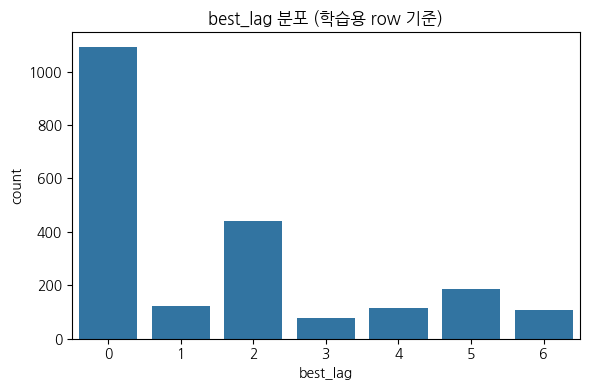

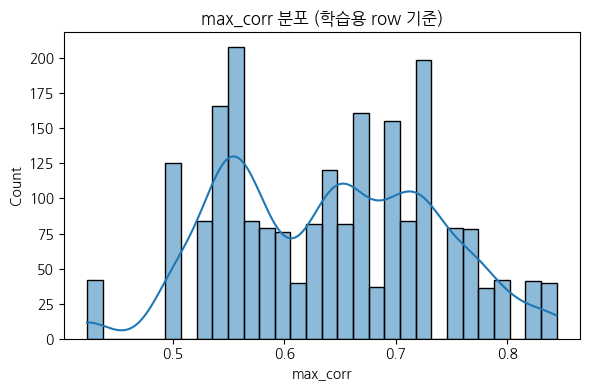

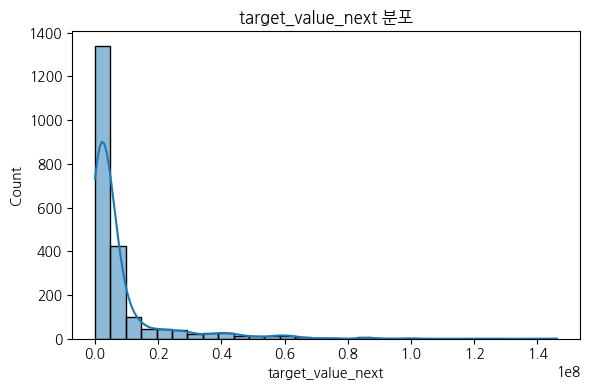

In [94]:
# 3-8. best_lag / max_corr / target 관련 간단 EDA

print("🧮 best_lag 분포:")
display(df_train_model_v2["best_lag"].value_counts().sort_index())

plt.figure(figsize=(6, 4))
sns.countplot(x="best_lag", data=df_train_model_v2)
plt.title("best_lag 분포 (학습용 row 기준)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_train_model_v2["max_corr"], bins=30, kde=True)
plt.title("max_corr 분포 (학습용 row 기준)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_train_model_v2[target_col], bins=30, kde=True)
plt.title("target_value_next 분포")
plt.tight_layout()
plt.show()

In [95]:
# 3-9. 학습용 데이터 저장 (parquet)

train_pair_path = PROCESSED_DIR / "train_pair_timeseries_v1.parquet"

df_train_model_v2.to_parquet(train_pair_path, index=False)

print("💾 학습용 df_train_model_v2 저장 완료! 😎")
print("📁 경로:", train_pair_path)
print("📦 최종 shape:", df_train_model_v2.shape)

💾 학습용 df_train_model_v2 저장 완료! 😎
📁 경로: /root/dacon/data/processed/train_pair_timeseries_v1.parquet
📦 최종 shape: (2140, 26)


##### 📌 4. 모델 학습 & 검증 (Markdown)

In [96]:
# 4-1. 캘린더 피처 + 아이템 인코딩 + 로그 타깃 생성

# ym이 datetime이 아니면 변환 (예: '2023-01' 문자열 등)
if not pd.api.types.is_datetime64_any_dtype(df_train_model_v2["ym"]):
    df_train_model_v2["ym_dt"] = pd.to_datetime(df_train_model_v2["ym"])
else:
    df_train_model_v2["ym_dt"] = df_train_model_v2["ym"]

# month, quarter 피처 생성
df_train_model_v2["month"] = df_train_model_v2["ym_dt"].dt.month
df_train_model_v2["quarter"] = df_train_model_v2["ym_dt"].dt.quarter

# following_item_id 를 OrdinalEncoder 로 숫자 인코딩
enc = OrdinalEncoder()
df_train_model_v2["item_enc"] = enc.fit_transform(
    df_train_model_v2[["following_item_id"]]
)

# 로그 타깃 생성
target_col = "target_value_next"
df_train_model_v2["target_log"] = np.log1p(df_train_model_v2[target_col])

print("🧩 feature/target 생성 완료!")
display(
    df_train_model_v2[
        [
            "leading_item_id",
            "following_item_id",
            "ym",
            "month",
            "quarter",
            "item_enc",
            target_col,
            "target_log",
        ]
    ].head()
)

🧩 feature/target 생성 완료!


,leading_item_id,following_item_id,ym,month,quarter,item_enc,target_value_next,target_log
0,VBYCLTYZ,ATLDMDBO,2022-03,3,1,0.0,121873741.0,18.618496
1,VBYCLTYZ,ATLDMDBO,2022-04,4,2,0.0,115024617.0,18.560657
2,VBYCLTYZ,ATLDMDBO,2022-05,5,2,0.0,65716075.0,18.000854
3,VBYCLTYZ,ATLDMDBO,2022-06,6,2,0.0,146216818.0,18.800601
4,BTMOEMEP,ATLDMDBO,2022-07,7,3,0.0,97552978.0,18.395906


In [97]:
# 4-2. 최종 피처 리스트 정의 & X, y 분리

# 기존 시계열 + 관계 피처
base_feature_cols = existing_feature_cols.copy()

# 새로 추가한 피처
extra_feature_cols = ["item_enc", "month", "quarter"]

# 실제로 존재하는 컬럼만 사용
all_candidate_cols = base_feature_cols + extra_feature_cols
feature_cols = [c for c in all_candidate_cols if c in df_train_model_v2.columns]

print("🎯 사용 피처 개수:", len(feature_cols))
print("📌 피처 리스트:")
for c in feature_cols:
    print("  -", c)

# X, y (원래 단위) + y_log (로그 단위)
X_all = df_train_model_v2[feature_cols].copy()
y_all = df_train_model_v2[target_col].copy()
y_all_log = df_train_model_v2["target_log"].copy()

print("\n📦 X_all shape:", X_all.shape)
print("🎯 y_all shape:", y_all.shape)

display(X_all.head())

🎯 사용 피처 개수: 15
📌 피처 리스트:
  - value
  - value_lag_1
  - value_lag_2
  - value_diff_1
  - value_pct_change_1
  - value_roll_mean_3
  - value_log
  - weight_log
  - value_per_kg
  - a_t_lag
  - max_corr
  - best_lag
  - item_enc
  - month
  - quarter

📦 X_all shape: (2140, 15)
🎯 y_all shape: (2140,)


,value,value_lag_1,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3,value_log,weight_log,value_per_kg,a_t_lag,max_corr,best_lag,item_enc,month,quarter
0,118403737.0,103568323.0,143097177.0,14835414.0,0.143243,1.216897e+08,18.589611,18.696784,0.898370,952075.0,0.730392,2,0.0,3,1
1,121873741.0,118403737.0,103568323.0,3470004.0,0.029307,1.146153e+08,18.618496,18.591618,1.027243,414564.0,0.730392,2,0.0,4,2
2,115024617.0,121873741.0,118403737.0,-6849124.0,-0.056199,1.184340e+08,18.560657,18.481793,1.082057,1119971.0,0.730392,2,0.0,5,2
3,65716075.0,115024617.0,121873741.0,-49308542.0,-0.428678,1.008715e+08,18.000854,17.970780,1.030531,838826.0,0.730392,2,0.0,6,2
4,146216818.0,65716075.0,115024617.0,80500743.0,1.224978,1.089858e+08,18.800601,18.814700,0.986000,54287660.0,0.689814,6,0.0,7,3


In [98]:
# 4-3. 시계열 기반 train / valid 분리 (마지막 N개월 = valid)

t_min = df_train_model_v2["t_idx"].min()
t_max = df_train_model_v2["t_idx"].max()
print("🕒 t_idx 범위:", t_min, "→", t_max)

N_VALID_STEPS = 3
valid_threshold = t_max - (N_VALID_STEPS - 1)
print(f"📆 validation t_idx 기준: {valid_threshold} 이상은 VALID 로 사용")

is_valid = df_train_model_v2["t_idx"] >= valid_threshold

X_train = X_all[~is_valid].reset_index(drop=True)
X_valid = X_all[is_valid].reset_index(drop=True)

y_train = y_all[~is_valid].reset_index(drop=True)
y_valid = y_all[is_valid].reset_index(drop=True)

y_train_log = y_all_log[~is_valid].reset_index(drop=True)
y_valid_log = y_all_log[is_valid].reset_index(drop=True)

print("🚂 X_train:", X_train.shape, "| y_train:", y_train.shape)
print("🧪 X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)

🕒 t_idx 범위: 0 → 41
📆 validation t_idx 기준: 39 이상은 VALID 로 사용
🚂 X_train: (1981, 15) | y_train: (1981,)
🧪 X_valid: (159, 15) | y_valid: (159,)


In [99]:
# 4-3-추가. train / valid ym 분포 확인

train_ym = df_train_model_v2.loc[~is_valid, "ym"]
valid_ym = df_train_model_v2.loc[is_valid, "ym"]

print("📆 train ym 고유값:", sorted(train_ym.unique())[:5], "... → 총", train_ym.nunique(), "개")
print("📆 valid ym 고유값:", sorted(valid_ym.unique()), "→ 총", valid_ym.nunique(), "개")

print("\n🔢 train vs valid row 비율")
print(" - train:", len(X_train))
print(" - valid:", len(X_valid))
print(" - valid 비율:", len(X_valid) / len(X_all), f"({len(X_valid) / len(X_all):.2%})")

📆 train ym 고유값: ['2022-01', '2022-02', '2022-03', '2022-04', '2022-05'] ... → 총 39 개
📆 valid ym 고유값: ['2025-04', '2025-05', '2025-06'] → 총 3 개

🔢 train vs valid row 비율
 - train: 1981
 - valid: 159
 - valid 비율: 0.07429906542056075 (7.43%)


In [100]:
# 4-4. 평가 지표 함수 정의

def nmae(y_true, y_pred):
    """평균 절대 오차를 타깃 평균으로 나눈 NMAE."""
    mae = mean_absolute_error(y_true, y_pred)
    denom = np.mean(np.abs(y_true))
    if denom == 0:
        return np.nan
    return mae / denom

print("✅ MAE / NMAE 평가 함수 준비 완료")

✅ MAE / NMAE 평가 함수 준비 완료


In [101]:
# 4-5. Baseline LinearRegression (log 타깃 + NaN Imputation)

# NaN 처리 (median) – LinearRegression 용
imputer = SimpleImputer(strategy="median")

print("🚀 NaN Imputation (median) 시작")
X_train_lr = imputer.fit_transform(X_train)
X_valid_lr = imputer.transform(X_valid)

print("🔎 X_train_lr NaN 합:", int(np.isnan(X_train_lr).sum()))
print("🔎 X_valid_lr NaN 합:", int(np.isnan(X_valid_lr).sum()))

linreg = LinearRegression()

print("🚀 Linear Regression (log 타깃) 학습 시작")
linreg.fit(X_train_lr, y_train_log)

# log-space 예측
y_train_pred_log_lr = linreg.predict(X_train_lr)
y_valid_pred_log_lr = linreg.predict(X_valid_lr)

# 원래 스케일로 복원
y_train_pred_lr = np.expm1(y_train_pred_log_lr)
y_valid_pred_lr = np.expm1(y_valid_pred_log_lr)

# 음수는 0으로 클리핑
y_train_pred_lr = np.clip(y_train_pred_lr, 0, None)
y_valid_pred_lr = np.clip(y_valid_pred_lr, 0, None)

# 성능 계산 (원래 스케일 기준)
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
valid_mae_lr = mean_absolute_error(y_valid, y_valid_pred_lr)

train_nmae_lr = nmae(y_train, y_train_pred_lr)
valid_nmae_lr = nmae(y_valid, y_valid_pred_lr)

print("📊 [LinearRegression (log target)] 성능")
print(f" - Train MAE : {train_mae_lr:,.0f}")
print(f" - Valid MAE : {valid_mae_lr:,.0f}")
print(f" - Train NMAE: {train_nmae_lr:.4f}")
print(f" - Valid NMAE: {valid_nmae_lr:.4f}")

🚀 NaN Imputation (median) 시작
🔎 X_train_lr NaN 합: 0
🔎 X_valid_lr NaN 합: 0
🚀 Linear Regression (log 타깃) 학습 시작
📊 [LinearRegression (log target)] 성능
 - Train MAE : 2,146,285
 - Valid MAE : 1,542,106
 - Train NMAE: 0.2739
 - Valid NMAE: 0.2982


In [102]:
# 4-6. Main 모델: LightGBMRegressor (log 타깃)

lgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.03,
    "max_depth": -1,
    "num_leaves": 63,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1,
}

lgbm = LGBMRegressor(**lgb_params)

print("🚀 LightGBMRegressor (log 타깃) 학습 시작! 🌱")
lgbm.fit(X_train, y_train_log)

# log-space 예측
y_train_pred_log_lgb = lgbm.predict(X_train)
y_valid_pred_log_lgb = lgbm.predict(X_valid)

# 원래 스케일로 복원
y_train_pred_lgb = np.expm1(y_train_pred_log_lgb)
y_valid_pred_lgb = np.expm1(y_valid_pred_log_lgb)

# 음수는 0으로 클리핑
y_train_pred_lgb = np.clip(y_train_pred_lgb, 0, None)
y_valid_pred_lgb = np.clip(y_valid_pred_lgb, 0, None)

# 성능 계산
train_mae_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
valid_mae_lgb = mean_absolute_error(y_valid, y_valid_pred_lgb)

train_nmae_lgb = nmae(y_train, y_train_pred_lgb)
valid_nmae_lgb = nmae(y_valid, y_valid_pred_lgb)

print("📊 [LightGBMRegressor (log target)] 성능")
print(f" - Train MAE : {train_mae_lgb:,.0f}")
print(f" - Valid MAE : {valid_mae_lgb:,.0f}")
print(f" - Train NMAE: {train_nmae_lgb:.4f}")
print(f" - Valid NMAE: {valid_nmae_lgb:.4f}")

🚀 LightGBMRegressor (log 타깃) 학습 시작! 🌱
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 1981, number of used features: 15
[LightGBM] [Info] Start training from score 14.777643
📊 [LightGBMRegressor (log target)] 성능
 - Train MAE : 124,654
 - Valid MAE : 1,929,269
 - Train NMAE: 0.0159
 - Valid NMAE: 0.3731


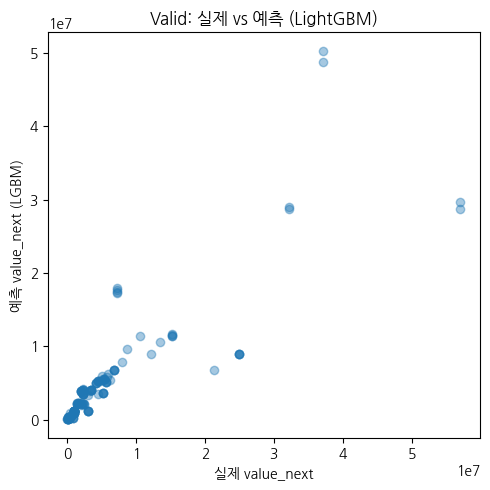

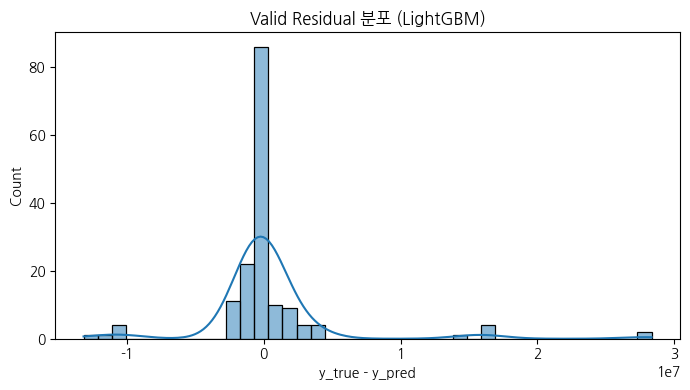

🔍 Residual 통계 (LGBM):


count    1.590000e+02
mean     3.876157e+05
std      4.836769e+06
min     -1.316871e+07
25%     -6.655891e+05
50%     -1.164556e+05
75%      8.567950e+04
max      2.834573e+07
Name: target_value_next, dtype: float64

In [103]:
# 4-7. LightGBM EDA: 예측 vs 실제 / Residual 분포

import matplotlib.pyplot as plt
import seaborn as sns

residuals_lgb = y_valid - y_valid_pred_lgb

plt.figure(figsize=(5, 5))
plt.scatter(y_valid, y_valid_pred_lgb, alpha=0.4)
plt.xlabel("실제 value_next")
plt.ylabel("예측 value_next (LGBM)")
plt.title("Valid: 실제 vs 예측 (LightGBM)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(residuals_lgb, bins=40, kde=True)
plt.title("Valid Residual 분포 (LightGBM)")
plt.xlabel("y_true - y_pred")
plt.tight_layout()
plt.show()

print("🔍 Residual 통계 (LGBM):")
display(pd.Series(residuals_lgb).describe())

In [104]:
# 4-8. LinearRegression vs LightGBMRegressor 성능 비교

compare_df = pd.DataFrame(
    {
        "model": ["LinearRegression_log", "LightGBMRegressor_log"],
        "train_MAE": [train_mae_lr, train_mae_lgb],
        "valid_MAE": [valid_mae_lr, valid_mae_lgb],
        "train_NMAE": [train_nmae_lr, train_nmae_lgb],
        "valid_NMAE": [valid_nmae_lr, valid_nmae_lgb],
    }
)

print("🏁 모델 성능 비교표")
display(compare_df)

🏁 모델 성능 비교표


,model,train_MAE,valid_MAE,train_NMAE,valid_NMAE
0,LinearRegression_log,2.146285e+06,1.542106e+06,0.273898,0.298223
1,LightGBMRegressor_log,1.246544e+05,1.929269e+06,0.015908,0.373096


In [105]:
# 4-9. 최종 모델 선택 & 전처리(인코더/임퓨터)와 함께 저장

import joblib
from pathlib import Path

MODEL_DIR = PROJECT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# valid NMAE 기준으로 더 좋은 모델 선택
if valid_nmae_lgb <= valid_nmae_lr:
    final_model = lgbm
    final_model_name = "LightGBMRegressor_log"
else:
    final_model = linreg
    final_model_name = "LinearRegression_log"

model_bundle = {
    "model": final_model,
    "model_name": final_model_name,
    "feature_cols": feature_cols,
    "item_encoder": enc,
    "imputer": imputer,  # LGBM 선택 시에도 그냥 함께 저장 (필요 시 활용)
}

model_path = MODEL_DIR / "final_model_v1.pkl"
joblib.dump(model_bundle, model_path)

print("💾 최종 모델 번들 저장 완료! 😎")
print("🔧 선택된 모델:", final_model_name)
print("📁 경로:", model_path)

💾 최종 모델 번들 저장 완료! 😎
🔧 선택된 모델: LinearRegression_log
📁 경로: /root/dacon/models/final_model_v1.pkl


##### 📌 5. 최종 예측 & 제출 파일 생성 (Markdown)

In [110]:
# 5-1. 저장된 모델 번들 및 sample_submission 로드

import joblib

# 모델 번들 로드
model_path = PROJECT_DIR / "models" / "final_model_v1.pkl"
model_bundle = joblib.load(model_path)

final_model = model_bundle["model"]
final_model_name = model_bundle["model_name"]
feature_cols = model_bundle["feature_cols"]
item_encoder = model_bundle["item_encoder"]
imputer = model_bundle["imputer"]

print("🤖 불러온 최종 모델:", final_model_name)
print("📌 feature_cols 개수:", len(feature_cols))

# sample_submission 로드
sample_path = DATA_DIR / "raw" / "sample_submission.csv"
sub = pd.read_csv(sample_path)

print("📄 sample_submission shape:", sub.shape)
display(sub.head())

🤖 불러온 최종 모델: LinearRegression_log
📌 feature_cols 개수: 15
📄 sample_submission shape: (9900, 3)


,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,999999999
1,DEWLVASR,AHMDUILJ,999999999
2,DEWLVASR,XIPPENFQ,999999999
3,DEWLVASR,FTSVTTSR,999999999
4,DEWLVASR,XMKRPGLB,999999999


In [111]:
# 5-2. 예측 기준 시점 정의 (마지막 t_idx = 2025-07)

t_idx_last = df_feat["t_idx"].max()
print("🕒 예측 기준 t_idx_last:", t_idx_last)

# follower(=following_item_id) 관측치 중 t_idx_last 에 해당하는 row 추출
# df_feat: item_id, ym, t_idx, 시계열 피처들 포함

follower_last = df_feat[df_feat["t_idx"] == t_idx_last].copy()
follower_last.rename(columns={"item_id": "following_item_id"}, inplace=True)

print("📦 follower_last shape:", follower_last.shape)
display(follower_last.head())

🕒 예측 기준 t_idx_last: 42
📦 follower_last shape: (90, 20)


,following_item_id,year,month,value,weight,quantity,date,ym,hs4,type,value_log,weight_log,value_per_kg,value_lag_1,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3,t_idx,target_value_next
28,AANGBULD,2025,7,533478.0,1046036.0,0.0,2025-07-01,2025-07,4810,1,13.187175,13.860519,0.510000,441275.0,38441.0,92203.0,0.208947,3.377313e+05,42,NaN
71,AHMDUILJ,2025,7,101317.0,34463.0,0.0,2025-07-01,2025-07,2102,1,11.526019,10.447671,2.939878,89479.0,127473.0,11838.0,0.132299,1.060897e+05,42,NaN
121,APQGTRMF,2025,7,40608.0,6314.0,0.0,2025-07-01,2025-07,8105,1,10.611745,8.750683,6.431422,32430.0,3543.0,8178.0,0.252174,2.552700e+04,42,NaN
164,ATLDMDBO,2025,7,57090235.0,165713328.0,0.0,2025-07-01,2025-07,2814,1,17.860144,18.925770,0.344512,32181798.0,37136720.0,24908437.0,0.773991,4.213625e+07,42,NaN
207,AXULOHBQ,2025,7,41989.0,2915.0,14907.0,2025-07-01,2025-07,5515,1,10.645187,7.977968,14.404460,65475.0,112061.0,-23486.0,-0.358702,7.317500e+04,42,NaN


In [112]:
# 5-3. comovement_pairs_v2 + follower_last 결합
# 각 (leading_item_id, following_item_id)에 대해 마지막 시점 follower 피처를 붙임

# comovement_pairs_v2: leading_item_id, following_item_id, best_lag, max_corr
pairs_base = comovement_pairs_v2.copy()

# follower_last 와 merge
inf_base = pairs_base.merge(
    follower_last,
    on="following_item_id",
    how="left",
)

print("🧷 inf_base (pair + follower_last) shape:", inf_base.shape)
display(
    inf_base[
        [
            "leading_item_id",
            "following_item_id",
            "ym",
            "t_idx",
            "best_lag",
            "max_corr",
            "value",
        ]
    ].head()
)

🧷 inf_base (pair + follower_last) shape: (53, 23)


,leading_item_id,following_item_id,ym,t_idx,best_lag,max_corr,value
0,QRKRBYJL,SDWAYPIK,2025-07,42,0,0.794249,6753962.0
1,DNMPSKTB,XUOIQPFL,2025-07,42,0,0.754678,2060879.0
2,SDWAYPIK,QVLMOEYE,2025-07,42,2,0.730036,1040638.0
3,GYHKIVQT,QVLMOEYE,2025-07,42,0,0.665974,1040638.0
4,ATLDMDBO,QVLMOEYE,2025-07,42,3,0.703682,1040638.0


In [113]:
# 5-4. leader 시점 인덱스 및 a_t_lag 붙이기

# t_idx_leader = t_idx_last - best_lag
inf_base["t_idx_leader"] = inf_base["t_idx"] - inf_base["best_lag"]

# df_feat에서 leader value 가져오기
leader_value_base_inf = (
    df_feat[["item_id", "t_idx", "value"]]
    .rename(
        columns={
            "item_id": "leading_item_id",
            "t_idx": "t_idx_leader",
            "value": "a_t_lag",
        }
    )
)

inf_base = inf_base.merge(
    leader_value_base_inf,
    on=["leading_item_id", "t_idx_leader"],
    how="left",
)

print("📦 inf_base (a_t_lag 포함) shape:", inf_base.shape)
print("🔎 a_t_lag 결측 개수:", inf_base["a_t_lag"].isnull().sum())
display(
    inf_base[
        [
            "leading_item_id",
            "following_item_id",
            "ym",
            "t_idx",
            "t_idx_leader",
            "best_lag",
            "max_corr",
            "value",
            "a_t_lag",
        ]
    ].head()
)

📦 inf_base (a_t_lag 포함) shape: (53, 25)
🔎 a_t_lag 결측 개수: 0


,leading_item_id,following_item_id,ym,t_idx,t_idx_leader,best_lag,max_corr,value,a_t_lag
0,QRKRBYJL,SDWAYPIK,2025-07,42,42,0,0.794249,6753962.0,3034748.0
1,DNMPSKTB,XUOIQPFL,2025-07,42,42,0,0.754678,2060879.0,4507669.0
2,SDWAYPIK,QVLMOEYE,2025-07,42,40,2,0.730036,1040638.0,4122827.0
3,GYHKIVQT,QVLMOEYE,2025-07,42,42,0,0.665974,1040638.0,25005326.0
4,ATLDMDBO,QVLMOEYE,2025-07,42,39,3,0.703682,1040638.0,42450439.0


In [114]:
# 5-5. 캘린더 피처 & item_enc 재생성 (학습 시와 동일 규칙)

# ym_dt 생성
if not pd.api.types.is_datetime64_any_dtype(inf_base["ym"]):
    inf_base["ym_dt"] = pd.to_datetime(inf_base["ym"])
else:
    inf_base["ym_dt"] = inf_base["ym"]

inf_base["month"] = inf_base["ym_dt"].dt.month
inf_base["quarter"] = inf_base["ym_dt"].dt.quarter

# following_item_id 를 encoder로 숫자 인코딩 (학습 때 fit 한 encoder 재사용)
inf_base["item_enc"] = item_encoder.transform(
    inf_base[["following_item_id"]]
)

print("🧩 inference용 feature 생성 완료!")
display(
    inf_base[
        [
            "leading_item_id",
            "following_item_id",
            "ym",
            "month",
            "quarter",
            "item_enc",
        ]
    ].head()
)

🧩 inference용 feature 생성 완료!


,leading_item_id,following_item_id,ym,month,quarter,item_enc
0,QRKRBYJL,SDWAYPIK,2025-07,7,3,13.0
1,DNMPSKTB,XUOIQPFL,2025-07,7,3,19.0
2,SDWAYPIK,QVLMOEYE,2025-07,7,3,9.0
3,GYHKIVQT,QVLMOEYE,2025-07,7,3,9.0
4,ATLDMDBO,QVLMOEYE,2025-07,7,3,9.0


In [115]:
# 5-6. 예측용 X_test 구성 (feature_cols 순서대로)

# feature_cols 에 없는 컬럼은 무시, 필요한 컬럼만 추출
missing_cols = [c for c in feature_cols if c not in inf_base.columns]
if missing_cols:
    print("⚠️ inf_base에 없는 feature 컬럼:", missing_cols)

X_test = inf_base[feature_cols].copy()

print("📦 X_test shape:", X_test.shape)
display(X_test.head())

📦 X_test shape: (53, 15)


,value,value_lag_1,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3,value_log,weight_log,value_per_kg,a_t_lag,max_corr,best_lag,item_enc,month,quarter
0,6753962.0,5199689.0,4122827.0,1554273.0,0.298917,5.358826e+06,15.725640,16.504245,0.459046,3034748.0,0.794249,0,13.0,7,3
1,2060879.0,2224223.0,3471983.0,-163344.0,-0.073439,2.585695e+06,14.538644,13.423499,3.050014,4507669.0,0.754678,0,19.0,7,3
2,1040638.0,951449.0,909197.0,89189.0,0.093740,9.670947e+05,13.855346,9.032529,124.329510,4122827.0,0.730036,2,9.0,7,3
3,1040638.0,951449.0,909197.0,89189.0,0.093740,9.670947e+05,13.855346,9.032529,124.329510,25005326.0,0.665974,0,9.0,7,3
4,1040638.0,951449.0,909197.0,89189.0,0.093740,9.670947e+05,13.855346,9.032529,124.329510,42450439.0,0.703682,3,9.0,7,3


In [116]:
# 5-7. 모델 종류에 따라 전처리 + 예측 실행

import numpy as np

print(f"🚀 최종 예측 시작! (model = {final_model_name})")

# LinearRegression_log 인 경우: 학습 시 imputer 사용 → 동일하게 적용
if "LinearRegression" in final_model_name:
    # NaN Imputation
    print("🧼 LinearRegression용 NaN Imputation 적용 중...")
    X_test_proc = imputer.transform(X_test)
else:
    # LightGBM은 NaN 허용 → 그대로 사용
    X_test_proc = X_test.values

# log-space 예측
y_pred_log = final_model.predict(X_test_proc)

# 원래 value 스케일로 복원
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)  # 음수는 0으로

inf_base["pred_value_next"] = y_pred

print("✅ 예측 완료!")
print("🔎 예측값 통계:")
display(inf_base["pred_value_next"].describe())

🚀 최종 예측 시작! (model = LinearRegression_log)
🧼 LinearRegression용 NaN Imputation 적용 중...
✅ 예측 완료!
🔎 예측값 통계:


count    5.300000e+01
mean     5.042043e+06
std      8.075316e+06
min      3.339977e+04
25%      1.053031e+06
50%      2.179696e+06
75%      5.036613e+06
max      3.938004e+07
Name: pred_value_next, dtype: float64

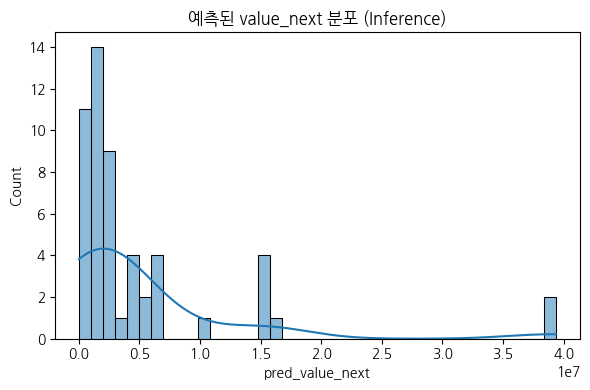

📌 상위 10개 예측값:


,leading_item_id,following_item_id,pred_value_next
19,VBYCLTYZ,ATLDMDBO,3.938004e+07
12,BTMOEMEP,ATLDMDBO,3.869863e+07
51,VBYCLTYZ,BTMOEMEP,1.626979e+07
47,QRKRBYJL,GYHKIVQT,1.536463e+07
16,SDWAYPIK,GYHKIVQT,1.534326e+07
45,JPBRUTWP,GYHKIVQT,1.520724e+07
15,VBYCLTYZ,GYHKIVQT,1.519803e+07
18,NZKBIBNU,WPQXWHYO,1.044361e+07
0,QRKRBYJL,SDWAYPIK,6.293664e+06
27,JPBRUTWP,SDWAYPIK,6.237699e+06


In [117]:
# 5-8. 예측 결과 EDA

plt.figure(figsize=(6, 4))
sns.histplot(inf_base["pred_value_next"], bins=40, kde=True)
plt.title("예측된 value_next 분포 (Inference)")
plt.tight_layout()
plt.show()

print("📌 상위 10개 예측값:")
display(
    inf_base[
        ["leading_item_id", "following_item_id", "pred_value_next"]
    ].sort_values("pred_value_next", ascending=False).head(10)
)

In [118]:
# 5-9. sample_submission과 예측 결과 매핑

pred_df = inf_base[
    ["leading_item_id", "following_item_id", "pred_value_next"]
].copy()

# 혹시 (leading, following) 중복이 있다면 평균으로 집계
pred_df = (
    pred_df.groupby(["leading_item_id", "following_item_id"], as_index=False)
    .agg({"pred_value_next": "mean"})
)

print("📦 pred_df (groupby 후) shape:", pred_df.shape)
display(pred_df.head())

# sample_submission과 merge
sub_pred = sub.merge(
    pred_df,
    on=["leading_item_id", "following_item_id"],
    how="left",
)

# 예측이 없는 쌍은 0으로 채우기 (필요 시 다른 룰로 변경 가능)
missing_pred = sub_pred["pred_value_next"].isnull().sum()
print("❓ 예측값이 없는 row 개수:", missing_pred)

sub_pred["value"] = sub_pred["pred_value_next"].fillna(0).round().astype(int)
sub_pred = sub_pred[["leading_item_id", "following_item_id", "value"]]

print("✅ submission용 DataFrame 생성 완료!")
display(sub_pred.head())

📦 pred_df (groupby 후) shape: (53, 3)


,leading_item_id,following_item_id,pred_value_next
0,ATLDMDBO,DNMPSKTB,4.422515e+06
1,ATLDMDBO,HXYSSRXE,5.139562e+06
2,ATLDMDBO,QRKRBYJL,2.388384e+06
3,ATLDMDBO,QVLMOEYE,1.027750e+06
4,ATLDMDBO,WBLJNPZQ,1.858273e+05


❓ 예측값이 없는 row 개수: 9847
✅ submission용 DataFrame 생성 완료!


,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,0
1,DEWLVASR,AHMDUILJ,0
2,DEWLVASR,XIPPENFQ,0
3,DEWLVASR,FTSVTTSR,0
4,DEWLVASR,XMKRPGLB,0


In [ ]:
# 5-10. submission 파일 저장

submit_path = PROJECT_DIR / "submissions" / "submission_v1.csv"
submit_path.parent.mkdir(parents=True, exist_ok=True)

sub_pred.to_csv(submit_path, index=False)

print("💾 submission_v1.csv 저장 완료! 🚀")
print("📁 경로:", submit_path)